In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec

In [3]:
from models import SBN
from utils import generate

In [41]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 'gray'] 

In [6]:
taxa = list('ABCDEFGH')
all_tree = generate(taxa)

In [7]:
tree_space_cap = len(all_tree)

In [18]:
for method in ['ccd', 'sbn-sa', 'sbn-em', 'sbn-em-alpha', 'freq']:
    if not os.path.exists('../results/simulation/' + method):
        os.makedirs('../results/simulation/' + method)
if not os.path.exists('../results/simulation/n-tree'):
    os.makedirs('../results/simulation/n-tree')

In [ ]:
beta_v = [0.001, 0.002, 0.004, 0.008, 0.016, 0.032]
K_v = [500, 1000, 2000, 4000, 8000]

reg_lam = 50.0
nrep = 10
kl_div_mat = np.empty((nrep,6,5,5))

for rep in range(nrep):
    output_ccd = '../results/simulation/ccd/rep' + '{:02d}'.format(rep)
    output_sbn = '../results/simulation/sbn-sa/rep' + '{:02d}'.format(rep)
    output_sbn_em = '../results/simulation/sbn-em/rep' + '{:02d}'.format(rep)
    output_sbn_em_alpha = '../results/simulation/sbn-em-alpha/rep' + '{:02d}'.format(rep)
    output_freq = '../results/simulation/freq/rep' + '{:02d}'.format(rep)
    output_n_unique_tree = '../results/simulation/n-tree/rep' +'{:02d}'.format(rep)
    
    kl_div_ccd = open(output_ccd, 'w')
    kl_div_sbn = open(output_sbn, 'w')
    kl_div_sbn_em = open(output_sbn_em, 'w')
    kl_div_sbn_em_alpha = open(output_sbn_em_alpha, 'w')
    kl_div_freq = open(output_freq, 'w')
    n_unique_tree = open(output_n_unique_tree, 'w')
    
    kl_div_ccd.write(''.ljust(8) + '\t'.join([str(n_tree).ljust(6) for n_tree in K_v]) +'\n')
    kl_div_sbn.write(''.ljust(8) + '\t'.join([str(n_tree).ljust(6) for n_tree in K_v]) +'\n')
    kl_div_sbn_em.write(''.ljust(8) + '\t'.join([str(n_tree).ljust(6) for n_tree in K_v]) +'\n')
    kl_div_sbn_em_alpha.write(''.ljust(8) + '\t'.join([str(n_tree).ljust(6) for n_tree in K_v]) +'\n')
    kl_div_freq.write(''.ljust(8) + '\t'.join([str(n_tree).ljust(6) for n_tree in K_v]) +'\n')
    n_unique_tree.write(''.ljust(8) + '\t'.join([str(n_tree).ljust(6) for n_tree in K_v]) +'\n')
    
    kl_div_ccd.flush()
    kl_div_sbn.flush()
    kl_div_sbn_em.flush()
    kl_div_sbn_em_alpha.flush()
    kl_div_freq.flush()
    n_unique_tree.flush()
    
    for l, beta in enumerate(beta_v):
        kl_div_ccd.write('{:.3f}'.format(beta))
        kl_div_sbn.write('{:.3f}'.format(beta))
        kl_div_sbn_em.write('{:.3f}'.format(beta))
        kl_div_sbn_em_alpha.write('{:.3f}'.format(beta))
        kl_div_freq.write('{:.3f}'.format(beta))
        n_unique_tree.write('{:.3f}'.format(beta))
        
        for j, n_trees in enumerate(K_v):
            samp_freq = np.random.dirichlet(beta*np.ones(tree_space_cap))
            emp_tree_freq = {tree:samp_freq[i] for i, tree in enumerate(all_tree) if samp_freq[i]>1e-20}

            samp_trees = np.random.choice(all_tree, n_trees, p=samp_freq)
            unique_samp_trees, samp_counts = np.unique(samp_trees, return_counts=True)

            tree_id = {tree.get_topology_id():[tree] for tree in unique_samp_trees}
            tree_count_dict = {tree.get_topology_id():samp_counts[i] for i, tree in enumerate(unique_samp_trees)}
            
            model = SBN(taxa, emp_tree_freq)
            print 'SBN-EM training: rep {}, beta {}, K {}'.format(rep, beta, n_trees)
            model.bn_train_count(tree_count_dict, tree_id)
            
            kl_div = model.kl_div()
            kl_div_mat[rep, l, j, 0], kl_div_mat[rep, l, j, 1] = kl_div['ccd'], kl_div['bn']
            kl_div_mat[rep, l, j, 4] = kl_div['freq']

            logp = model.bn_em_count(tree_count_dict, tree_id, maxiter=200, abstol=1e-05, monitor=True, MAP=False)
            kl_div_mat[rep, l, j, 2] = model.kl_div(method='bn')['bn']

            model = SBN(taxa, emp_tree_freq, alpha=reg_lam/n_trees)  
            print 'SBN-EM-ALPHA training: rep {}, beta {}, K {}'.format(rep, beta, n_trees)
            logp = model.bn_em_count(tree_count_dict, tree_id, maxiter=200, abstol=1e-05, monitor=True, MAP=True)
            kl_div_mat[rep, l, j, 3] = model.kl_div(method='bn', MAP=True)['bn']

            kl_div_ccd.write('\t{:.4f}'.format(kl_div_mat[rep, l, j, 0]))
            kl_div_sbn.write('\t{:.4f}'.format(kl_div_mat[rep, l, j, 1]))
            kl_div_sbn_em.write('\t{:.4f}'.format(kl_div_mat[rep, l, j, 2]))
            kl_div_sbn_em_alpha.write('\t{:.4f}'.format(kl_div_mat[rep, l, j, 3]))
            kl_div_freq.write('\t{:.4f}'.format(kl_div_mat[rep, l, j, 4]))
            n_unique_tree.write('\t'+str(len(samp_counts)).ljust(6))
            
            kl_div_ccd.flush()
            kl_div_sbn.flush()
            kl_div_sbn_em.flush()
            kl_div_sbn_em_alpha.flush()
            kl_div_freq.flush()
            n_unique_tree.flush()
        
        kl_div_ccd.write('\n')
        kl_div_sbn.write('\n')
        kl_div_sbn_em.write('\n')
        kl_div_sbn_em_alpha.write('\n')
        kl_div_freq.write('\n')
        n_unique_tree.write('\n')
        
    kl_div_ccd.close()
    kl_div_sbn.close()
    kl_div_sbn_em.close()
    kl_div_sbn_em_alpha.close()
    kl_div_freq.close()
    n_unique_tree.close()

In [39]:
kl_div_mean = np.mean(kl_div_mat, axis=0)
kl_div_std = np.std(kl_div_mat, axis=0)

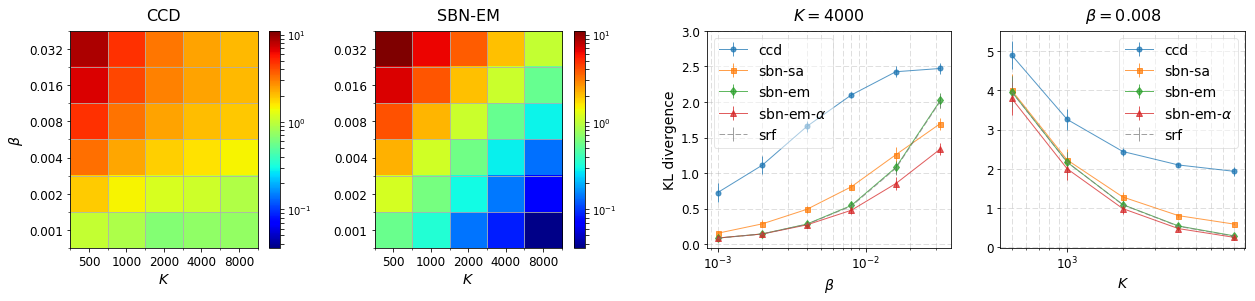

In [42]:
fig = plt.figure(figsize=(17, 4))
gs1 = gridspec.GridSpec(1,2)
gs1.update(left=0.02, right=0.46, wspace=0.3)
ax0 = plt.subplot(gs1[0,0])
ccd_kl_div = kl_div_mean[:,:,0]
im = ax0.imshow(ccd_kl_div, origin='lower', cmap='jet', norm=LogNorm(vmin=kl_div_mean.min(), vmax=kl_div_mean.max()))
cbar = plt.colorbar(im, ax=ax0)
ax0.set_aspect('auto')
ax0.set_xticks(range(5))
ax0.set_yticks(range(6))
ax0.set_xticks(np.arange(-0.5,5,1), minor=True)
ax0.set_yticks(np.arange(-0.5,6,1), minor=True)
ax0.set_xticklabels([500, 1000, 2000, 4000, 8000])
ax0.set_yticklabels([0.001,0.002,0.004,0.008,0.016,0.032])
ax0.grid(which='minor')
ax0.tick_params(labelsize=12)
ax0.set_xlabel(r'$K$', fontsize=14)
ax0.set_ylabel(r'$\beta$', fontsize=14)
ax0.set_title('CCD', fontsize=16, y=1.02)


ax1 = plt.subplot(gs1[0,1])
sbn_em_kl_div = kl_div_mean[:,:,2]
im = ax1.imshow(sbn_em_kl_div, origin='lower', cmap='jet', norm=LogNorm(vmin=kl_div_mean.min(), vmax=kl_div_mean.max()))
cbar = plt.colorbar(im, ax=ax1)
ax1.set_aspect('auto')
ax1.set_xticks(range(5))
ax1.set_yticks(range(6))
ax1.set_xticks(np.arange(-0.5,5,1), minor=True)
ax1.set_yticks(np.arange(-0.5,6,1), minor=True)
ax1.set_xticklabels([500, 1000, 2000, 4000, 8000])
ax1.set_yticklabels([0.001,0.002,0.004,0.008,0.016,0.032])
ax1.grid(which='minor')
ax1.tick_params(labelsize=12)
ax1.set_xlabel(r'$K$', fontsize=14)
ax1.set_title('SBN-EM', fontsize=16, y=1.02)

gs2 = gridspec.GridSpec(1,2)
gs2.update(left=0.54, right=0.98, wspace=0.2)
ax2 = plt.subplot(gs2[0,0])

labels={0:'ccd',1:'sbn-sa',2:'sbn-em',3:'sbn-em-'+r'$\alpha$',4:'srf'}
fmts={0:'-o',1:'-s',2:'-d',3:'-^',4:'--'}
marksz={0:5,1:5,2:6,3:6,4:0}

beta_v = [0.001, 0.002, 0.004, 0.008, 0.016, 0.032]
k = 3
ax2.set_xscale('log')
for i in [0,1,2,3,4]:
    ax2.errorbar(beta_v, kl_div_mean[:,k,i], yerr=kl_div_std[:,k,i], c=colors[i], label=labels[i], fmt=fmts[i],markersize=marksz[i], alpha=0.75, linewidth=1)

leg = ax2.legend(loc='best',fontsize=14)
leg.get_frame().set_alpha(0.5)
ax2.grid(which='both', linestyle='--', alpha=0.5)
ax2.tick_params(labelsize=12)
ax2.set_xlabel(r'$\beta$', fontsize=14)
ax2.set_ylabel('KL divergence', fontsize=14)
ax2.set_title(r'$K=4000$', y=1.02, fontsize=16)
ax2.set_ylim(top=3)

ax3 = plt.subplot(gs2[0,1])
K_v = [500, 1000, 2000, 4000, 8000]
l = 3
ax3.set_xscale('log')

for i in [0,1,2,3,4]:
    ax3.errorbar(K_v, kl_div_mean[l,:,i], yerr=kl_div_std[l,:,i], c=colors[i], label=labels[i], fmt=fmts[i], markersize=marksz[i], alpha=0.75, linewidth=1)

leg = ax3.legend(loc='best',fontsize=14)
leg.get_frame().set_alpha(0.5)
ax3.grid(which='both', linestyle='--', alpha=0.5)
ax3.tick_params(labelsize=12)
ax3.set_xlabel(r'$K$', fontsize=14)
ax3.set_title(r'$\beta=0.008$', y=1.02, fontsize=16)
plt.show()